In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets , models ,transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [7]:
import os
print(os.listdir("/kaggle/input"))
# print(os.listdir("/kaggle/input/microsoft-catsvsdogs-dataset"))


['PetImages', 'readme[1].txt', 'MSR-LA - 3467.docx']


In [11]:
import shutil

# Copy dataset from read-only input directory to working directory
shutil.copytree(
    "/kaggle/input",
    "/kaggle/working/dataset"
)


'/kaggle/working/dataset'

In [ ]:
import shutil

shutil.copytree(
    "/kaggle/working/dataset/PetImages",
    "kaggle/working/Data"
)

In [ ]:
from PIL import Image
import os

def remove_corrupted_images(root_dir):
    total_deleted = 0
    for class_name in ['Cat', 'Dog']:
        class_path = os.path.join(root_dir, class_name)
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                print(f"Deleting corrupted file: {file_path}")
                os.remove(file_path)
                total_deleted += 1
    print(f"\n✅ Done. Total corrupted images removed: {total_deleted}")

# Clean from the working copy
remove_corrupted_images("/kaggle/working/dataset/PetImages")


In [12]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image

# Set seed for reproducibility
random.seed(42)

# Source and destination directories
source_dir = Path("/kaggle/working/dataset/PetImages")  # Your original folder
dest_dir = Path("/kaggle/working")  # Output will be here

categories = ['Cat', 'Dog']  # Note: Use correct case — 'Cat' and 'Dog' in PetImages
split_ratio = 0.8  # 80% train, 20% test

for category in categories:
    img_dir = source_dir / category
    if not img_dir.exists():
        print(f"Directory {img_dir} does not exist.")
        continue

    images = list(img_dir.glob("*.jpg"))  # Only use .jpg files
    valid_images = []

    # Filter out corrupted images
    for img_path in images:
        try:
            img = Image.open(img_path)
            img.verify()
            valid_images.append(img_path)
        except Exception:
            continue  # Skip corrupted images

    random.shuffle(valid_images)
    split_idx = int(len(valid_images) * split_ratio)
    train_imgs = valid_images[:split_idx]
    test_imgs = valid_images[split_idx:]

    for split, split_imgs in zip(["train", "test"], [train_imgs, test_imgs]):
        split_path = dest_dir / split / category.lower()  # cat and dog in lowercase
        split_path.mkdir(parents=True, exist_ok=True)

        for img in split_imgs:
            shutil.copy(img, split_path / img.name)

print("Dataset split completed.")


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dataset split completed.


In [13]:
from torchvision import transforms


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([
    transforms.Resize((128,128)),              
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


test_transforms = transforms.Compose([
    transforms.Resize((128,128)),            
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [14]:
train_data_path = "/kaggle/working/train"

train_dataset = datasets.ImageFolder(train_data_path , transform = train_transforms)

test_data_path = "kaggle/working/test"

test_dataset = datasets.ImageFolder("/kaggle/working/test" , transform = test_transforms)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True , pin_memory=True )
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False ,pin_memory=True)

In [ ]:
model = models.resnet34(pretrained= False)


num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 2)
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [19]:
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
patience = 3
counter = 0

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)

epochs = 25
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = calculate_accuracy(model, train_loader, device)
    test_acc = calculate_accuracy(model, test_loader, device)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    scheduler.step(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_wts)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/25
Train Loss: 0.7298, Train Acc: 0.6677, Test Acc: 0.6702

Epoch 2/25
Train Loss: 0.6266, Train Acc: 0.7256, Test Acc: 0.7336

Epoch 3/25
Train Loss: 0.5502, Train Acc: 0.7676, Test Acc: 0.7674

Epoch 4/25
Train Loss: 0.4907, Train Acc: 0.7899, Test Acc: 0.7788

Epoch 5/25
Train Loss: 0.4415, Train Acc: 0.8003, Test Acc: 0.8130

Epoch 6/25
Train Loss: 0.4003, Train Acc: 0.8317, Test Acc: 0.8296

Epoch 7/25
Train Loss: 0.3794, Train Acc: 0.8481, Test Acc: 0.8458

Epoch 8/25
Train Loss: 0.3475, Train Acc: 0.8549, Test Acc: 0.8508

Epoch 9/25
Train Loss: 0.3217, Train Acc: 0.8384, Test Acc: 0.8454

Epoch 10/25
Train Loss: 0.3048, Train Acc: 0.8466, Test Acc: 0.8440

Epoch 11/25
Train Loss: 0.2642, Train Acc: 0.9024, Test Acc: 0.8946

Epoch 12/25
Train Loss: 0.2468, Train Acc: 0.9037, Test Acc: 0.8904

Epoch 13/25
Train Loss: 0.2356, Train Acc: 0.9063, Test Acc: 0.8972

Epoch 14/25
Train Loss: 0.2241, Train Acc: 0.9147, Test Acc: 0.8980

Epoch 15/25
Train Loss: 0.2146, Train Acc:

<All keys matched successfully>

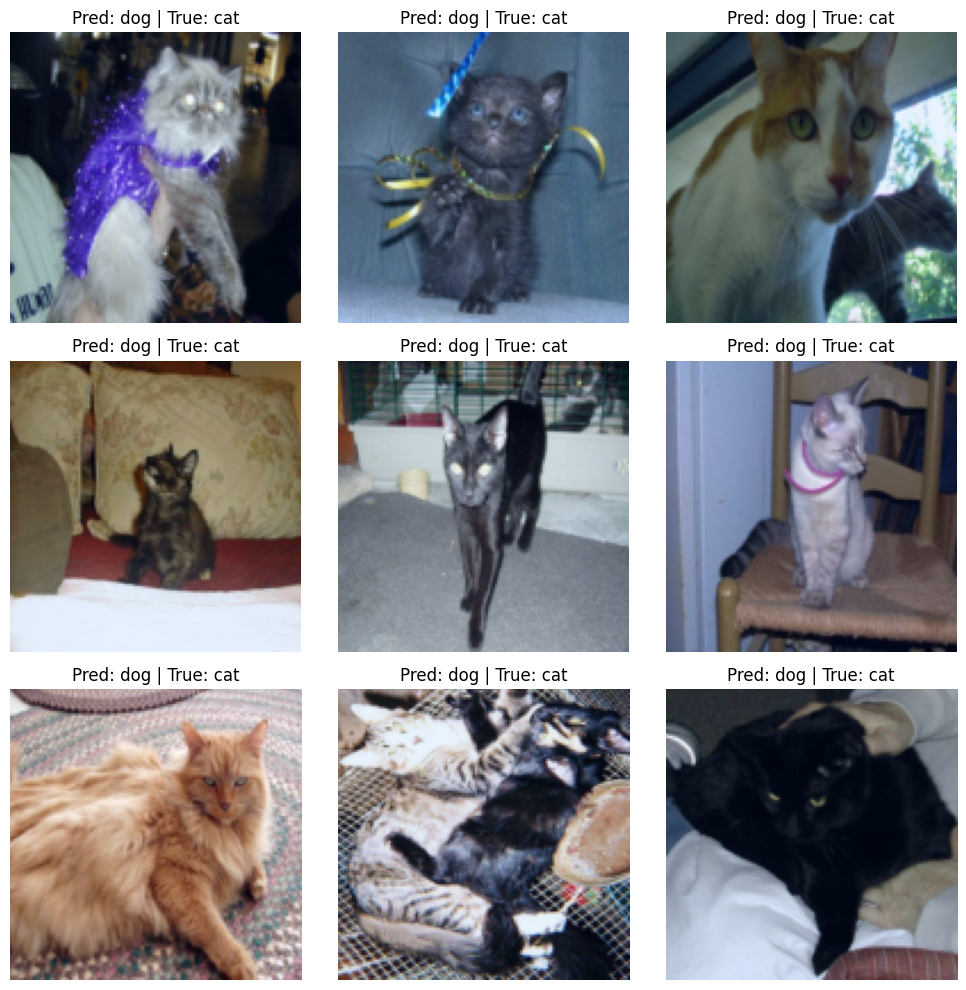

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np


misclassified = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for img, pred, true in zip(images, preds, labels):
            if pred != true:
                misclassified.append((img.cpu(), pred.cpu(), true.cpu()))
        if len(misclassified) >= 25:
            break


class_names = ['cat', 'dog']

plt.figure(figsize=(10, 10))
for i in range(9):
    img, pred, true = misclassified[i]
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min()) 

    plt.subplot(3,3,  i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred]} | True: {class_names[true]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


<Figure size 600x600 with 0 Axes>

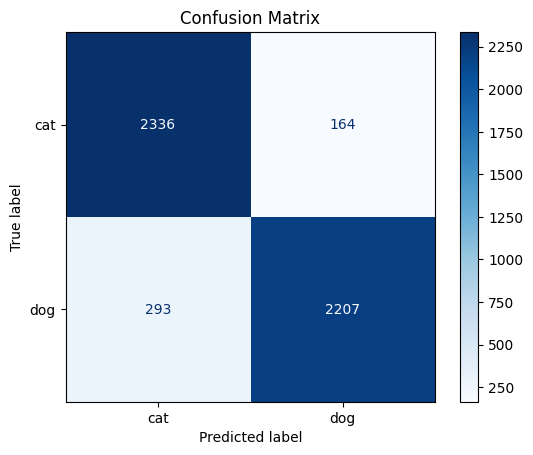

In [22]:
class_names = ['cat', 'dog']
plot_confusion_matrix(model, test_loader, class_names, device)
